Exploratory data analysis for compcars

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

parts_fn = 'D:\\Datasets\\CompCars\\data\\part'
whole_fn = 'D:\\Datasets\\CompCars\\data\\image'
print(parts_fn)

D:\Datasets\CompCars\data\part


In [2]:
import glob
# count the number of files, is it the same as the number expected?
skip_counting = False
if not skip_counting:
    print(parts_fn +  '\\**\\*.jpg')
    parts_images = glob.glob(parts_fn +  '\\**\\*.jpg', recursive=True)
    print(len(parts_images)) # should be 27618
    #print(whole_fn +  '\\**\\*.jpg')
    #whole_images = glob.glob(whole_fn +  '\\**\\*.jpg', recursive=True)
    #print(len(whole_images)) # should be 136727

D:\Datasets\CompCars\data\part\**\*.jpg
27618


In [3]:
# create lookup tables for makes, models, parts
import scipy.io
lut_fn = 'D:\\Datasets\\CompCars\\data\\misc'
car_type_mat = scipy.io.loadmat(lut_fn + '\\car_type.mat')

# specifically designed to load types from CompCars car_type.mat cell array
def get_car_types_list(mat):
    num_types = len(mat['types'][0])
    car_types = [mat['types'][0][i][0] for i in range(num_types)]
    return ['other', *car_types]

# specifically designed to load types from CompCars car_type.mat cell array
def get_make_model_list(mat):
    num_makes = len(mat['make_names'])
    make_names = [mat['make_names'][i][0][0] for i in range(num_makes)]
    num_models = len(mat['model_names'])
    model_names = []
    for i in range(num_models):
        mn = mat['model_names'][i][0]
        if len(mn) == 0:
            model_names.append('UNK')
        else:
            model_names.append(mn[0])
    return make_names, model_names
car_types = get_car_types_list(car_type_mat)
make_model_name_mat = scipy.io.loadmat(lut_fn + '\\make_model_name.mat')
make_names, model_names = get_make_model_list(make_model_name_mat)

whole_views = {-1:'unc',1:'F', 2:'R', 3:'S', 4:'FS', 5:'RS'}
part_views = {1:'HeadLight', 2:'TailLight', 3:'FogLight', 4:'AirIntake', 5:'Console', 6:'Steering', 7:'Dashboard', 8:'GearLever'}

In [4]:
# create pandas dataframe for attributes
attributes = pd.read_csv(lut_fn + '\\attributes.txt', delimiter=' ') # 0 indicates unknown
int(attributes[attributes['model_id']==1]['type'])

4

In [5]:
car_types

['other',
 'MPV',
 'SUV',
 'sedan',
 'hatchback',
 'minibus',
 'fastback',
 'estate',
 'pickup',
 'hardtop convertible',
 'sports',
 'crossover',
 'convertible']

In [6]:
# construct a list of the number of available views for each model
def read_part_for_info(fp, counter):
    df = pd.read_csv(fp, delimiter='/', header=None) # ['make_id', 'model_id', 'year', 'view', 'filename']
    counter = counter.copy()
    for row in df.iterrows():
        r = row[1]
        counter[r[0]-1,r[1]-1,r[3]-1] += 1
    return counter
    
part_split_fn = 'D:\\Datasets\\CompCars\\data\\train_test_split\\part'

parts_tr = np.zeros((len(make_names),len(model_names),len(part_views)))
parts_te = np.zeros((len(make_names),len(model_names),len(part_views)))

for i in glob.glob(part_split_fn + '\\train_*.txt'):
    parts_tr = read_part_for_info(i, parts_tr)
# show an example of the number of images per view for one of the models
parts_tr[77][1]

array([9., 8., 9., 8., 8., 7., 8., 8.])

In [7]:
# construct a dataframe for the models using only the make/model combos that show up
tr_list = []
te_list = []
for i in range(len(make_names)):
    for j in range(len(model_names)):
        if sum(parts_tr[i][j]) > 0:
            tr_list.append([i, j, *parts_tr[i][j]]) #* means pass the list as a variable-sized input of scalars instead of list
        if sum(parts_te[i][j]) > 0:
            te_list.append([i, j, *parts_te[i][j]])
tr_parts = pd.DataFrame(tr_list, columns=['make_ID', 'model_ID', *part_views.values()])
te_parts = pd.DataFrame(tr_list, columns=['make_ID', 'model_ID', *part_views.values()])
print(tr_parts['make_ID'].unique() + 1)
print(te_parts['make_ID'].unique() + 1)

# from this we can see that the training and test set go through the same classes. 
# However, some makes/models in the dataset such as make 7 and make 19, are skipped, generally due to a lack of data.

[  4  11  14  15  26  27  28  29  34  35  36  37  38  39  43  45  48  50
  51  53  54  55  58  64  68  69  70  71  73  75  76  77  78  80  81  82
  84  87  88  89  92  94  95  97 100 102 103 105 106 108 111 114 118 119
 120 121 122 128 131 132 133 134 138 140 142 148 149 150 152 155 157 158
 159 160 162]
[  4  11  14  15  26  27  28  29  34  35  36  37  38  39  43  45  48  50
  51  53  54  55  58  64  68  69  70  71  73  75  76  77  78  80  81  82
  84  87  88  89  92  94  95  97 100 102 103 105 106 108 111 114 118 119
 120 121 122 128 131 132 133 134 138 140 142 148 149 150 152 155 157 158
 159 160 162]


In [8]:
for p in (tr_parts, te_parts):
    p['make'] = [make_names[x] for x in p['make_ID']]
    p['model'] = [model_names[x] for x in p['model_ID']]
    p['make_ID_folder'] = p['make_ID'] + 1
    p['model_ID_folder'] = p['model_ID'] + 1
tr_parts

,make_ID,model_ID,HeadLight,TailLight,FogLight,AirIntake,Console,Steering,Dashboard,GearLever,make,model,make_ID_folder,model_ID_folder
0,3,508,4.0,4.0,5.0,4.0,5.0,4.0,4.0,4.0,DS,DS 5,4,509
1,3,510,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,DS,DS 5LS,4,511
2,3,511,3.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,DS,DS 3,4,512
3,3,515,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,DS,DS 4,4,516
4,10,734,7.0,8.0,7.0,6.0,7.0,6.0,6.0,7.0,Jeep,Wrangler,11,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,161,1632,4.0,4.0,2.0,3.0,3.0,3.0,3.0,3.0,MAZDA,Mazda 3,162,1633
427,161,1633,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,MAZDA,Mazda 3 Xingcheng hatchback,162,1634
428,161,1634,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,MAZDA,Mazda 3 Xingcheng sedan,162,1635
429,161,1635,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,MAZDA,Mazda CX-5,162,1636


In [9]:
# construct a dict of views for each make/model combo, structured as
# dict[make][model][year] = {Headlight:[fp1, fp2, ..], TailLight:..., ... }

def dict_factory(make, model, year):
    # return make, model, then 8 empty lists
    car_type_int = int(attributes[attributes['model_id']==model]['type'])
    car_type = car_types[car_type_int]
    
    make_model = {'make_ID':make, 'model_ID':model, 'year':year, 'type':car_type,
                  'make':make_names[make-1], 'model':model_names[model-1]}
    empty_lists = {i:[] for i in part_views}
    return {**make_model, **empty_lists} # combine the two dictionaries

# construct a list of the number of available views for each model
def read_part_collect_dict(fp, dicts):
    with open(fp) as f:
        lines = [line.rstrip('\n') for line in f] # ['make_id', 'model_id', 'year', 'view', 'filename']
    dicts = dicts.copy()
    for l in lines:
        r = l.split('/')
        make, model, year, view, fn = int(r[0]), int(r[1]), int(r[2]), int(r[3]), r[4]
        if not dicts.get((make, model, year)):
            dicts[(make, model, year)] = dict_factory(make, model, year)
        dicts[(make, model, year)][view].append(l)
    return dicts
    
part_split_fn = 'D:\\Datasets\\CompCars\\data\\train_test_split\\part'
tr_dict = {}
for i in glob.glob(part_split_fn + '\\train_*.txt'):
    tr_dict = read_part_collect_dict(i, tr_dict)
te_dict = {}
for i in glob.glob(part_split_fn + '\\test_*.txt'):
    te_dict = read_part_collect_dict(i, te_dict)
    
print(len(tr_dict))
print(len(te_dict))

1191
1183


In [10]:
attributes['type'].value_counts()

0     748
3     290
2     200
4     158
5      71
1      60
10     56
8      46
6      22
9      22
12     16
7      14
11     13
Name: type, dtype: int64

In [11]:
tr_dict.get((78, 1, 2013))

{'make_ID': 78,
 'model_ID': 1,
 'year': 2013,
 'type': 'hatchback',
 'make': 'Audi',
 'model': 'Audi A3 hatchback',
 1: ['78/1/2013/1/02dba947d556ab.jpg'],
 2: ['78/1/2013/2/59c53c1e5dcd25.jpg'],
 3: ['78/1/2013/3/0ef2cc28213b81.jpg'],
 4: ['78/1/2013/4/ea644cdf16f213.jpg'],
 5: ['78/1/2013/5/46ccad8ce908e6.jpg'],
 6: ['78/1/2013/6/9b9da35df6daa9.jpg', '78/1/2013/6/46115e9bc87c57.jpg'],
 7: ['78/1/2013/7/1f287310609534.jpg'],
 8: []}

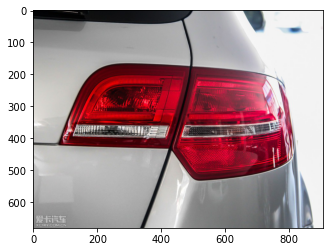

In [12]:
# try loading one image 
example_img = tr_dict.get((78, 1, 2013))[2][0]
img = plt.imread(parts_fn + '\\' + example_img)
plt.imshow(img)

In [13]:
# # count the effective number of cars (by adding the minimum number of parts per category)
# def count_effective_cars(dicts):
#     total_effective_ncars = 0
#     for k in dicts.keys():
#         v = dicts.get(k)
#         num_parts = [len(v[i+1]) for i in range(8)]
#         effective_ncars = np.min(num_parts)
#         total_effective_ncars += effective_ncars
#         print('c = {}, {}, nc = {}'.format(v['make'], v['model'], effective_ncars))
#     return total_effective_ncars

(681, 908, 3)
(681, 908, 3)
(681, 908, 3)
(626, 908, 3)
(681, 908, 3)
(681, 908, 3)
(681, 908, 3)
(224, 224, 3)
['D:\\Datasets\\CompCars\\data\\part\\78/1/2013/1/02dba947d556ab.jpg', 'D:\\Datasets\\CompCars\\data\\part\\78/1/2013/2/59c53c1e5dcd25.jpg', 'D:\\Datasets\\CompCars\\data\\part\\78/1/2013/3/0ef2cc28213b81.jpg', 'D:\\Datasets\\CompCars\\data\\part\\78/1/2013/4/ea644cdf16f213.jpg', 'D:\\Datasets\\CompCars\\data\\part\\78/1/2013/5/46ccad8ce908e6.jpg', 'D:\\Datasets\\CompCars\\data\\part\\78/1/2013/6/46115e9bc87c57.jpg', 'D:\\Datasets\\CompCars\\data\\part\\78/1/2013/7/1f287310609534.jpg', None]


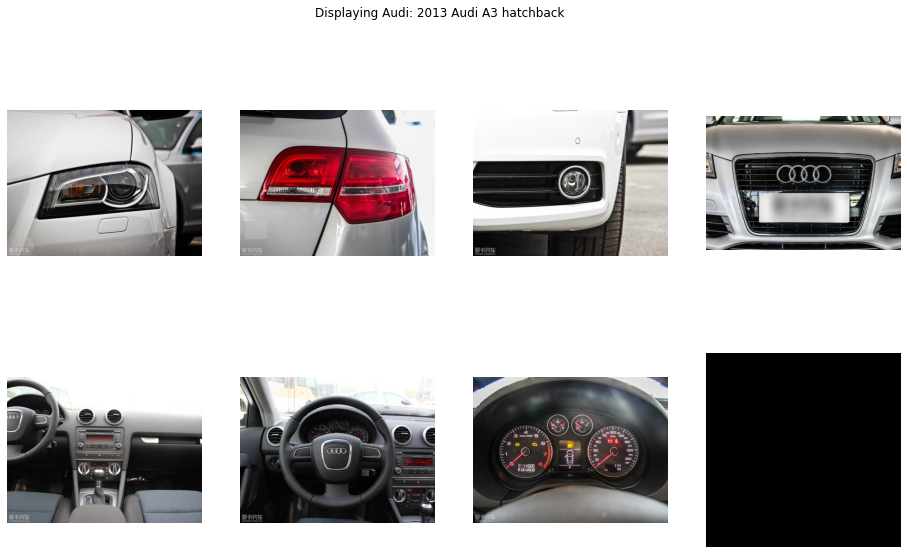

In [14]:
# load an example from the "dataset"
example = tr_dict.get((78, 1, 2013))

def get_images_and_mask(data_dict, num_views, path_prefix=None):
    example_images = []
    example_paths = []
    for i in range(num_views):
        part_i_images = data_dict[i+1]
        if part_i_images: # if there is a list of images pick a random image
            rand_index = np.random.randint(len(part_i_images))
            img_path = parts_fn + '\\' + data_dict[i+1][rand_index]
            img = plt.imread(img_path)
            example_images.append(img)
            example_paths.append(img_path)
        else: # no image, fill with blanks
            img = np.zeros((224,224,3))
            example_images.append(img)
            example_paths.append(None)
    return example_images, example_paths

ei, ep = get_images_and_mask(example, len(part_views), path_prefix=parts_fn)
for i in range(len(ei)):
    print(ei[i].shape)
print(ep)

def visualize_bag(data_dict):
    # print out the make, model, year
    title = 'Displaying {}: {} {}'.format(data_dict['make'], data_dict['year'], data_dict['model'])
    ei, _ = get_images_and_mask(example, len(part_views), path_prefix=parts_fn)
    fig, axs = plt.subplots(2, 4, clear=True, figsize=(16,9))
    fig.suptitle(title)
    for r in range(2):
        for c in range(4):
            axs[r, c].imshow(ei[4*r+c])
            axs[r, c].axis('off')
    plt.show()
    
visualize_bag(example)

In [15]:
# save the dictionaries for reading later
import pickle
part_split_fn = 'D:\\Datasets\\CompCars\\data\\train_test_split\\part'

def save_dict_as_pickle(dct, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_dict_from_pickle(filename):
    with open(filename, 'rb') as handle:
        dct = pickle.load(handle)
        return dct

save_dict_as_pickle(tr_dict, part_split_fn + '\\tr_dict.pickle')
save_dict_as_pickle(te_dict, part_split_fn + '\\te_dict.pickle')

load_test = load_dict_from_pickle(part_split_fn + '\\tr_dict.pickle')
tr_dict == load_test

True

Subsequent cells are delegated to dataloader-related debugging

In [16]:
# demonstrating join function
p1 = 'D:/Datasets/CompCars/data'
p2 = 'train_test_split/part/tr_dict.pickle'
print(os.path.join(p1, p2))

load_test = load_dict_from_pickle(os.path.join(p1, p2))
tr_dict == load_test

D:/Datasets/CompCars/data\train_test_split/part/tr_dict.pickle


True

In [17]:
# collect a group of car models
models = []
model_to_classind = {}
classind_to_model = {}
for k in tr_dict.keys():
    models.append(tr_dict[k]['model'])
# only keep unique entries
model_set = sorted(set(models))
# make a bidirectional dictionary for entries
for ind, m in enumerate(model_set):
    model_to_classind[m] = ind
    classind_to_model[ind] = m
classind_to_model

{0: 'ASX abroad version',
 1: 'AVEO hatchback',
 2: 'Accord',
 3: 'Alphard',
 4: 'Alto',
 5: 'Antara',
 6: 'Arrizo 7',
 7: 'Atenza',
 8: 'Audi A1',
 9: 'Audi A3 hatchback',
 10: 'Audi A3 sedan',
 11: 'Audi A4 estate',
 12: 'Audi A4L',
 13: 'Audi A5 convertible',
 14: 'Audi A5 coupe',
 15: 'Audi A5 hatchback',
 16: 'Audi A6L',
 17: 'Audi A7',
 18: 'Audi A8L',
 19: 'Audi Q3',
 20: 'Audi Q5',
 21: 'Audi Q7',
 22: 'Audi S5 convertible',
 23: 'Audi S8',
 24: 'Audi TT coupe',
 25: 'Audi TTS coupe',
 26: 'Avante',
 27: 'Aveo',
 28: 'Aveo sedan',
 29: 'Axela sedan',
 30: 'BAW E Series hatchback',
 31: 'BAW E Series sedan ',
 32: 'BWM 1 Series hatchback',
 33: 'BWM 2 Series',
 34: 'BWM 3 Series',
 35: 'BWM 3 Series GT',
 36: 'BWM 3 Series convertible',
 37: 'BWM 3 Series coupe',
 38: 'BWM 3 Series estate',
 39: 'BWM 4 Series convertible',
 40: 'BWM 5 Series',
 41: 'BWM 5 Series GT',
 42: 'BWM 6 Series',
 43: 'BWM 7 Series',
 44: 'BWM M5',
 45: 'BWM X1',
 46: 'BWM X3',
 47: 'BWM X4',
 48: 'BWM X

In [18]:
# get color-channel averages and stds for each view
part_split_fn = 'D:\\Datasets\\CompCars\\data\\train_test_split\\part'

macro_means = []
macro_stds = []
for fp in glob.glob(part_split_fn + '\\train*.txt'):
    image_means = []
    image_stds = []
    print(fp)
    with open(fp) as f:
        lines = [line.rstrip('\n') for line in f]
    for l in lines:
        # read the image and find its mean
        img = plt.imread(parts_fn + '\\' + l) / 256.0
        image_m = [np.mean(img[i]) for i in range(3)]
        image_std = [np.std(img[i]) for i in range(3)]
        image_means.append(image_m)
        image_stds.append(image_std)
    image_means = np.mean(np.array(image_means),axis=0)
    image_stds = np.mean(np.array(image_stds), axis=0)
    print('image means' + str(image_means))
    print('image stds' + str(image_stds))
    macro_means.append(image_means)
    macro_stds.append(image_stds)
print(np.mean(np.array(macro_means),axis=0))
print(np.mean(np.array(macro_stds),axis=0))

D:\Datasets\CompCars\data\train_test_split\part\train_part_1.txt
image means[0.51307756 0.51391858 0.51474671]
image stds[0.20678634 0.20678639 0.2068244 ]
D:\Datasets\CompCars\data\train_test_split\part\train_part_2.txt
image means[0.55588403 0.55620269 0.55654704]
image stds[0.21798134 0.21795691 0.21823526]
D:\Datasets\CompCars\data\train_test_split\part\train_part_3.txt


KeyboardInterrupt: 

In [ ]:
image_means

In [ ]:
# try loading one image 
example_img = tr_dict.get((78, 1, 2013))[2][0]
img = plt.imread(parts_fn + '\\' + example_img)
plt.imshow(img)
np.mean(img[0])